In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0005,0.0004,100.0,258.0,0.355972,0.370523,0.308580,1.0,...,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,2.0,0.0008,-0.0003,100.0,257.0,0.388759,0.399100,0.309360,1.0,...,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,3.0,-0.0014,-0.0002,100.0,256.0,0.313817,0.353298,0.445398,1.0,...,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,4.0,-0.0020,0.0001,100.0,255.0,0.487119,0.417107,0.237285,1.0,...,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,5.0,0.0016,0.0000,100.0,254.0,0.196721,0.476218,0.321217,1.0,...,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


La seguente funzione *process_targets* è la cosiddetta funzione **lineare a tratti** di cui parliamo estensivamente all'interno del readme ci permette dunque di calcolare il valore della RUL da assegnare ad ogni elemento del dataset. 
La funzione prende in input la lunghezza totale dei dati e la *"early_rul"* la quale rappresenta il valore massimo possibile di RUL (imponiamo ciò poiché come descritto dalla letteratura dovrebbe permettere alla rete di comprendere meglio quando il componente è in salute o meno), il quale poi viene decrementato in maniera lineare quando la *"data_length"* supera il valore di *early_rul*

In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

*process_input_data_with_targets* è invece la funzione addetta a "sistemare" i valori all'interno delle loro proprie sequenze di *window_length* valori. 

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:
new_FD0001.head()

,unit_number,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,0.355972,0.370523,0.308580,0.208812,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,0.388759,0.399100,0.309360,0.236590,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,0.313817,0.353298,0.445398,0.230843,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,0.487119,0.417107,0.237285,0.268199,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,0.196721,0.476218,0.321217,0.245690,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


In [9]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [10]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (21820, 30, 14)
Processed training ruls shape:  (21820,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [12]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


2023-10-09 15:06:09.512810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:06:10.237040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/home/aliquodfahriam/miniconda3/envs/tensorflowEnv/lib/
2023-10-09 15:06:10.237129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/

In [13]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score] )
    return model


In [14]:
LSTMsmallModel = createLSTMsmallModel(60, 30, 30, 15, (30, 14)) 

2023-10-09 15:06:10.767358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 15:06:10.772697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 15:06:10.772914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 15:06:10.773340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [15]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 50 #100 / 80 / 150 

path_small = './models/LSTMsmall/FD0001_scoreFixed'



model_checkpoint = ModelCheckpoint(
    path_small,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)



In [17]:
history = LSTMsmallModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50


2023-10-09 15:06:14.668990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


67/69 [============================>.] - ETA: 0s - loss: 1620.7319 - custom_score: 106018.0234
Epoch 1: val_loss improved from inf to 1409.58215, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 10s 97ms/step - loss: 1618.6426 - custom_score: 103331.0469 - val_loss: 1409.5822 - val_custom_score: 19410.3516 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
65/69 [===========================>..] - ETA: 0s - loss: 1126.3212 - custom_score: 17076.5332
Epoch 2: val_loss improved from 1409.58215 to 469.61792, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 84ms/step - loss: 1098.6423 - custom_score: 16380.3223 - val_loss: 469.6179 - val_custom_score: 6310.5010 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
65/69 [===========================>..] - ETA: 0s - loss: 382.5547 - custom_score: 3409.6172
Epoch 3: val_loss improved from 469.61792 to 336.09033, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 86ms/step - loss: 381.5455 - custom_score: 3337.7759 - val_loss: 336.0903 - val_custom_score: 2548.8030 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 343.8472 - custom_score: 2748.3708
Epoch 4: val_loss improved from 336.09033 to 295.99939, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 88ms/step - loss: 343.8472 - custom_score: 2748.3708 - val_loss: 295.9994 - val_custom_score: 1840.7886 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 277.3823 - custom_score: 1772.9271
Epoch 5: val_loss improved from 295.99939 to 263.06668, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 88ms/step - loss: 277.3823 - custom_score: 1772.9271 - val_loss: 263.0667 - val_custom_score: 1119.0974 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/50
68/69 [============================>.] - ETA: 0s - loss: 224.8316 - custom_score: 1215.2677
Epoch 6: val_loss did not improve from 263.06668
69/69 [==============================] - 1s 10ms/step - loss: 224.9061 - custom_score: 1201.1399 - val_loss: 308.0485 - val_custom_score: 2449.4375 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/50
69/69 [==============================] - ETA: 0s - loss: 215.5007 - custom_score: 1132.9449
Epoch 7: val_loss improved from 263.06668 to 201.38927, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 94ms/step - loss: 215.5007 - custom_score: 1132.9449 - val_loss: 201.3893 - val_custom_score: 839.7377 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/50
65/69 [===========================>..] - ETA: 0s - loss: 208.3683 - custom_score: 1081.0558
Epoch 8: val_loss did not improve from 201.38927
69/69 [==============================] - 1s 10ms/step - loss: 207.9496 - custom_score: 1075.1844 - val_loss: 227.2870 - val_custom_score: 846.3199 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 9/50
66/69 [===========================>..] - ETA: 0s - loss: 193.6831 - custom_score: 965.3025
Epoch 9: val_loss did not improve from 201.38927
69/69 [==============================] - 1s 10ms/step - loss: 193.6487 - custom_score: 956.1132 - val_loss: 207.2484 - val_custom_score: 774.3003 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 90ms/step - loss: 192.1092 - custom_score: 968.4222 - val_loss: 183.0062 - val_custom_score: 852.5085 - lr: 0.0100

Epoch 11: LearningRateScheduler setting learning rate to 0.001.
Epoch 11/50
64/69 [==========================>...] - ETA: 0s - loss: 177.7992 - custom_score: 871.0459
Epoch 11: val_loss did not improve from 183.00621
69/69 [==============================] - 1s 11ms/step - loss: 177.4747 - custom_score: 859.0885 - val_loss: 183.4585 - val_custom_score: 761.8990 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.001.
Epoch 12/50
63/69 [==========================>...] - ETA: 0s - loss: 177.5832 - custom_score: 863.6260
Epoch 12: val_loss improved from 183.00621 to 182.27969, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 94ms/step - loss: 176.8488 - custom_score: 855.6992 - val_loss: 182.2797 - val_custom_score: 762.8400 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.001.
Epoch 13/50
64/69 [==========================>...] - ETA: 0s - loss: 176.3684 - custom_score: 860.4709
Epoch 13: val_loss improved from 182.27969 to 178.66130, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 97ms/step - loss: 175.8730 - custom_score: 845.6652 - val_loss: 178.6613 - val_custom_score: 768.1222 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.001.
Epoch 14/50
62/69 [=========================>....] - ETA: 0s - loss: 173.8985 - custom_score: 842.5192
Epoch 14: val_loss improved from 178.66130 to 176.90836, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 89ms/step - loss: 173.8223 - custom_score: 832.2662 - val_loss: 176.9084 - val_custom_score: 795.5723 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.001.
Epoch 15/50
66/69 [===========================>..] - ETA: 0s - loss: 173.4053 - custom_score: 839.7768
Epoch 15: val_loss improved from 176.90836 to 175.74684, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 92ms/step - loss: 173.0222 - custom_score: 829.2878 - val_loss: 175.7468 - val_custom_score: 838.4964 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.001.
Epoch 16/50
67/69 [============================>.] - ETA: 0s - loss: 172.2179 - custom_score: 836.1092
Epoch 16: val_loss improved from 175.74684 to 175.50093, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 98ms/step - loss: 172.2133 - custom_score: 828.2264 - val_loss: 175.5009 - val_custom_score: 757.9378 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.001.
Epoch 17/50
64/69 [==========================>...] - ETA: 0s - loss: 170.9907 - custom_score: 825.4694
Epoch 17: val_loss improved from 175.50093 to 174.61049, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 96ms/step - loss: 171.5568 - custom_score: 822.8653 - val_loss: 174.6105 - val_custom_score: 756.5942 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/50
68/69 [============================>.] - ETA: 0s - loss: 171.4837 - custom_score: 835.8615
Epoch 18: val_loss improved from 174.61049 to 173.27655, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 96ms/step - loss: 171.3653 - custom_score: 825.0913 - val_loss: 173.2766 - val_custom_score: 776.1925 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.001.
Epoch 19/50
64/69 [==========================>...] - ETA: 0s - loss: 170.9989 - custom_score: 834.5531
Epoch 19: val_loss did not improve from 173.27655
69/69 [==============================] - 1s 10ms/step - loss: 170.5833 - custom_score: 829.0089 - val_loss: 178.2701 - val_custom_score: 725.1643 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.001.
Epoch 20/50
63/69 [==========================>...] - ETA: 0s - loss: 169.3323 - custom_score: 826.3267
Epoch 20: val_loss improved from 173.27655 to 170.90895, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 96ms/step - loss: 169.0940 - custom_score: 813.9366 - val_loss: 170.9090 - val_custom_score: 789.9753 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0001.
Epoch 21/50
68/69 [============================>.] - ETA: 0s - loss: 167.3988 - custom_score: 817.5837
Epoch 21: val_loss did not improve from 170.90895
69/69 [==============================] - 1s 10ms/step - loss: 167.4242 - custom_score: 808.2484 - val_loss: 171.0302 - val_custom_score: 760.8008 - lr: 1.0000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0001.
Epoch 22/50
65/69 [===========================>..] - ETA: 0s - loss: 166.8337 - custom_score: 804.9268
Epoch 22: val_loss improved from 170.90895 to 170.78554, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 103ms/step - loss: 167.3119 - custom_score: 796.9087 - val_loss: 170.7855 - val_custom_score: 759.3960 - lr: 1.0000e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0001.
Epoch 23/50
69/69 [==============================] - ETA: 0s - loss: 167.1488 - custom_score: 805.2990
Epoch 23: val_loss improved from 170.78554 to 170.50346, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 108ms/step - loss: 167.1488 - custom_score: 805.2990 - val_loss: 170.5035 - val_custom_score: 768.0856 - lr: 1.0000e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0001.
Epoch 24/50
69/69 [==============================] - ETA: 0s - loss: 167.0443 - custom_score: 805.6396
Epoch 24: val_loss improved from 170.50346 to 170.36897, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 105ms/step - loss: 167.0443 - custom_score: 805.6396 - val_loss: 170.3690 - val_custom_score: 790.7683 - lr: 1.0000e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0001.
Epoch 25/50
65/69 [===========================>..] - ETA: 0s - loss: 167.1378 - custom_score: 812.4780
Epoch 25: val_loss did not improve from 170.36897
69/69 [==============================] - 1s 10ms/step - loss: 167.0870 - custom_score: 805.6284 - val_loss: 170.4739 - val_custom_score: 802.2554 - lr: 1.0000e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0001.
Epoch 26/50
65/69 [===========================>..] - ETA: 0s - loss: 167.3135 - custom_score: 808.4078
Epoch 26: val_loss improved from 170.36897 to 170.13838, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 99ms/step - loss: 166.9061 - custom_score: 797.2622 - val_loss: 170.1384 - val_custom_score: 766.7662 - lr: 1.0000e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0001.
Epoch 27/50
62/69 [=========================>....] - ETA: 0s - loss: 166.6579 - custom_score: 813.7963
Epoch 27: val_loss did not improve from 170.13838
69/69 [==============================] - 1s 8ms/step - loss: 166.6701 - custom_score: 797.6142 - val_loss: 170.4320 - val_custom_score: 749.3000 - lr: 1.0000e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0001.
Epoch 28/50
67/69 [============================>.] - ETA: 0s - loss: 166.3468 - custom_score: 804.4233
Epoch 28: val_loss improved from 170.13838 to 169.89403, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 6s 93ms/step - loss: 166.5932 - custom_score: 799.8449 - val_loss: 169.8940 - val_custom_score: 794.0967 - lr: 1.0000e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0001.
Epoch 29/50
68/69 [============================>.] - ETA: 0s - loss: 166.6058 - custom_score: 809.8829
Epoch 29: val_loss did not improve from 169.89403
69/69 [==============================] - 1s 12ms/step - loss: 166.7114 - custom_score: 802.1208 - val_loss: 170.1268 - val_custom_score: 749.2186 - lr: 1.0000e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0001.
Epoch 30/50
66/69 [===========================>..] - ETA: 0s - loss: 166.5657 - custom_score: 805.4864
Epoch 30: val_loss did not improve from 169.89403
69/69 [==============================] - 1s 12ms/step - loss: 166.4535 - custom_score: 793.4448 - val_loss: 170.1065 - val_custom_score: 747.6707 - lr: 1.0000e-04

Epoch 31: LearningRateScheduler setting learning rate to 1e-05.
Epoch 31

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 102ms/step - loss: 166.0429 - custom_score: 791.3320 - val_loss: 169.6926 - val_custom_score: 759.2632 - lr: 1.0000e-05

Epoch 32: LearningRateScheduler setting learning rate to 1e-05.
Epoch 32/50
65/69 [===========================>..] - ETA: 0s - loss: 165.9645 - custom_score: 809.2896
Epoch 32: val_loss did not improve from 169.69263
69/69 [==============================] - 1s 11ms/step - loss: 166.0317 - custom_score: 799.4493 - val_loss: 169.8151 - val_custom_score: 753.3058 - lr: 1.0000e-05

Epoch 33: LearningRateScheduler setting learning rate to 1e-05.
Epoch 33/50
66/69 [===========================>..] - ETA: 0s - loss: 165.6505 - custom_score: 801.8287
Epoch 33: val_loss did not improve from 169.69263
69/69 [==============================] - 1s 11ms/step - loss: 166.0065 - custom_score: 795.3792 - val_loss: 169.8105 - val_custom_score: 753.5081 - lr: 1.0000e-05

Epoch 34: LearningRateScheduler setting learning rate to 1e-05.
Epoch 34/

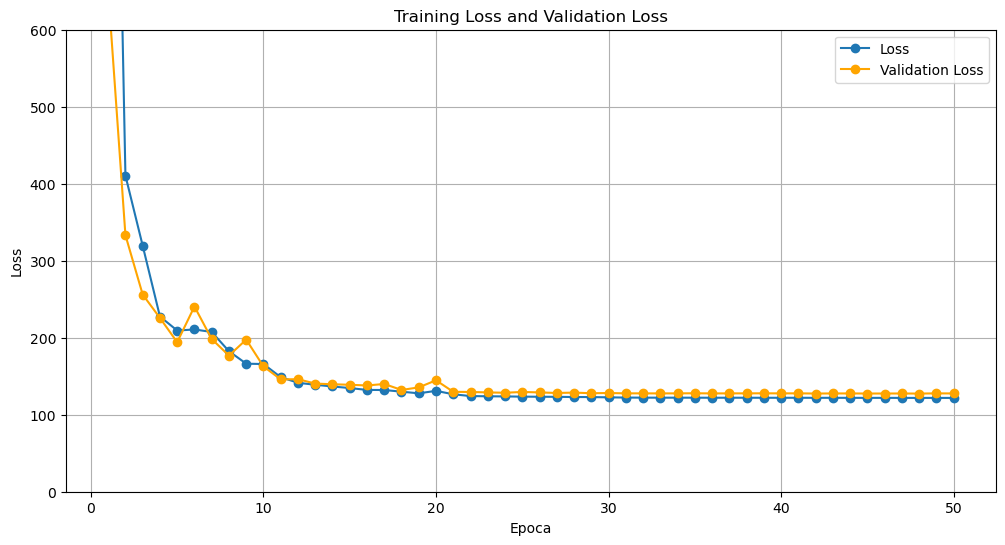

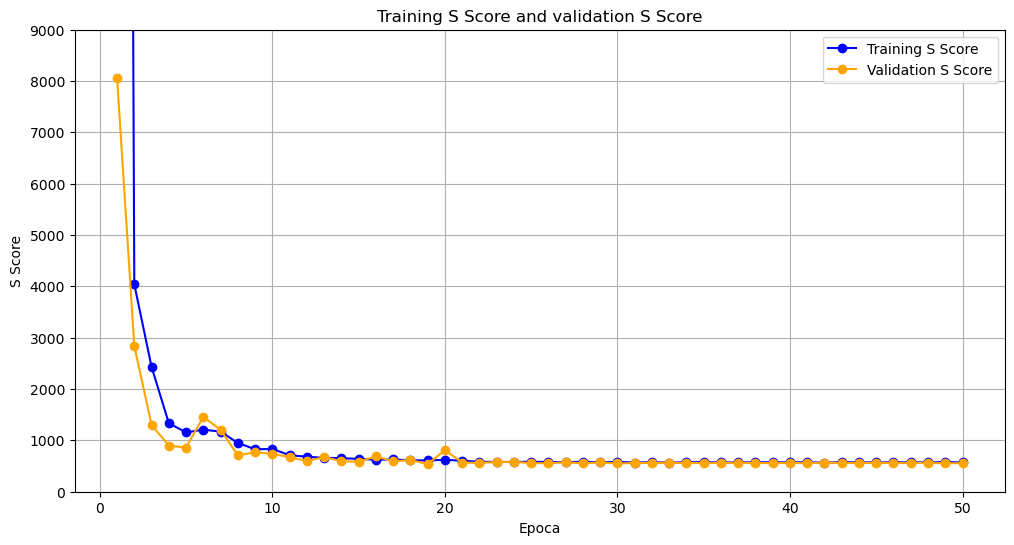

In [ ]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


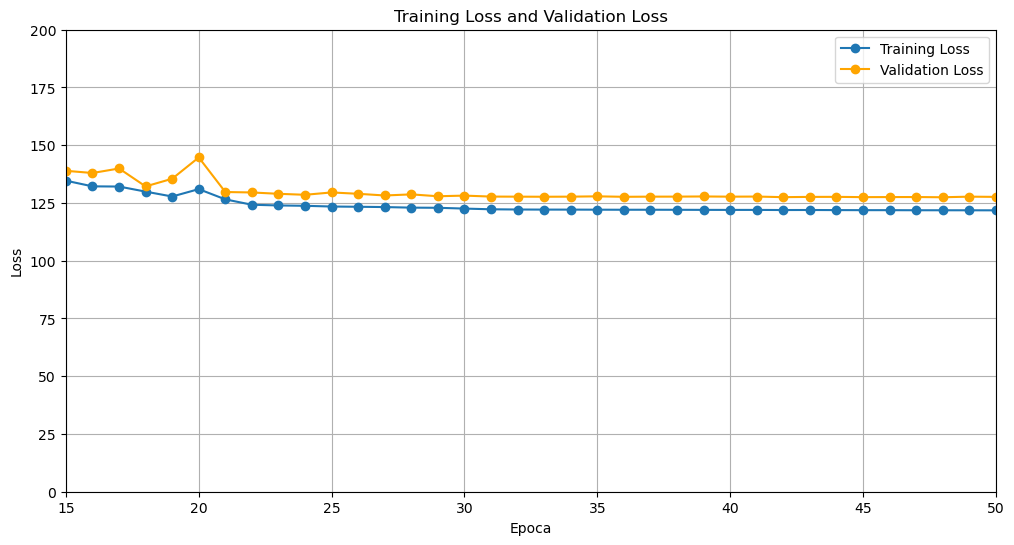

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 200)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()


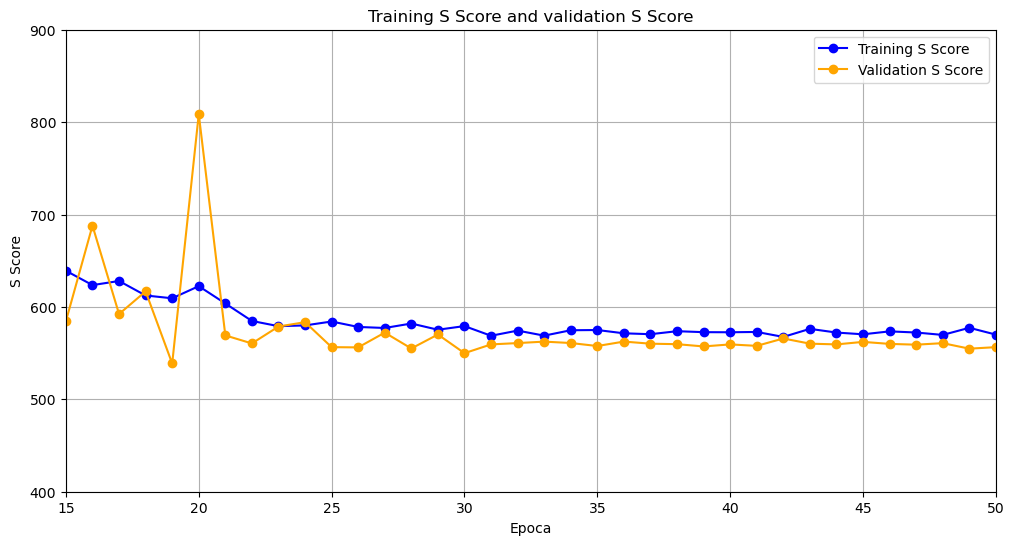

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(400, 900)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova'
run_model = tf.function(lambda x: LSTMsmallModel(x))
BATCH_SIZE = 256
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMsmallModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMsmallModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMsmallModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("small_lstm_fixed.tflite", "wb") as f:
    f.write(tflite_model)